In [2]:
import np as np

import Ramsey_ExperimentV3
from tqdm import tqdm
import random

import estimator
import numpy as np

In [129]:
fitted_data = []
T = 1 * np.pi
uni_delay = np.linspace(0, T, 20)
shots = 1000

uniform_local_G = []
n = 1
delay = [1]
fisher_delay = [0.4439410861020235, 1.784695781691183]

decay_fit = []

repetitions = 50
# W =]
W = np.arange(0.001, 3.1, 0.25)
# np.delete(W, 0)
Decay = np.arange(0.001, 3.1, 0.25)
J = {}
J_list = [random.gauss(1, 0) for _ in range(n - 1)]
for rep in tqdm(range(repetitions), desc="Repetition"):
    rep_decay_fit = []
    for w in W:
        for d in Decay:
            # Create experiments
            batch_x_det, batch_y_det, batch_x_cross, batch_y_cross = Ramsey_ExperimentV3.ramsey_local(
                n, shots, delay, [d], [w], J
            )
            batch_det, batch_cross = Ramsey_ExperimentV3.ramsey_local_X(n, shots, fisher_delay, [d], [w], J)
            batch_x_det_uni, batch_y_det_uni, batch_x_cross_uni, batch_y_cross_uni = Ramsey_ExperimentV3.ramsey_local(
                n, shots, uni_delay, [d], [w], J
            )

            # Append batches and decay to decay fit list
            rep_decay_fit.append((
                w,d,
                (batch_x_det, batch_y_det, batch_x_cross, batch_y_cross),
                (batch_det, batch_cross),
                (batch_x_det_uni, batch_y_det_uni, batch_x_cross_uni, batch_y_cross_uni),
            ))

    decay_fit.append(rep_decay_fit)

Repetition: 100%|██████████| 50/50 [06:10<00:00,  7.41s/it]


In [130]:

from importlib import reload
reload(estimator)

<module 'estimator' from 'C:\\Projects\\Crosstalk\\estimator.py'>

In [131]:

for rep, rep_batches in enumerate(decay_fit):
    rep_fits = []
    print(f"Repetition {rep} / {repetitions}")
    for w, d,(batch_x_det, batch_y_det, batch_x_cross, batch_y_cross), (batch_det, batch_cross), (batch_x_det_uni, batch_y_det_uni, batch_x_cross_uni, batch_y_cross_uni) in rep_batches:
        Decay_local, W_local, J_local = estimator.one_by_one_fit(batch_x_det, batch_y_det, batch_x_cross, batch_y_cross)
        Decay_fisher, W_fisher, J_fisher = estimator.one_by_one_X(batch_det, batch_cross)
        Decay_uni, W_uni, J_uni = estimator.one_by_one_fit(batch_x_det_uni, batch_y_det_uni, batch_x_cross_uni, batch_y_cross_uni)

        rep_fits.append((
            w,d,
            (Decay_local, W_local, J_local),
            (Decay_fisher, W_fisher, J_fisher),
            (Decay_uni, W_uni, J_uni),
        ))

    fitted_data.append(rep_fits)

Repetition 0 / 50


C:\Projects\Crosstalk\estimator.py:36: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance, *c = curve_fit(model_func, t_points, z_points, p0=initial_guess, bounds=bounds)
C:\Projects\Crosstalk\estimator.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance, *c = curve_fit(model_func, t_points, z_points, p0=initial_guess, bounds=bounds)


Repetition 1 / 50
Repetition 2 / 50
Repetition 3 / 50
Repetition 4 / 50
Repetition 5 / 50
Repetition 6 / 50
Repetition 7 / 50
Repetition 8 / 50
Repetition 9 / 50
Repetition 10 / 50
Repetition 11 / 50
Repetition 12 / 50
Repetition 13 / 50
Repetition 14 / 50
Repetition 15 / 50
Repetition 16 / 50
Repetition 17 / 50
Repetition 18 / 50
Repetition 19 / 50
Repetition 20 / 50
Repetition 21 / 50
Repetition 22 / 50
Repetition 23 / 50
Repetition 24 / 50
Repetition 25 / 50
Repetition 26 / 50
Repetition 27 / 50
Repetition 28 / 50
Repetition 29 / 50
Repetition 30 / 50
Repetition 31 / 50
Repetition 32 / 50
Repetition 33 / 50
Repetition 34 / 50
Repetition 35 / 50
Repetition 36 / 50
Repetition 37 / 50
Repetition 38 / 50
Repetition 39 / 50
Repetition 40 / 50
Repetition 41 / 50
Repetition 42 / 50
Repetition 43 / 50
Repetition 44 / 50
Repetition 45 / 50
Repetition 46 / 50
Repetition 47 / 50
Repetition 48 / 50
Repetition 49 / 50


In [132]:
from importlib import reload
reload(estimator)
errors_fisher = []
errors_local = []
uniform_local = []
for rep, rep_fits in enumerate(fitted_data):
    rep_error_fisher = []
    rep_error_local = []
    rep_error_uniform = []

    for w,d, (Decay_local, W_local, J_local), (Decay_fisher, W_fisher, J_fisher), (Decay_uni, W_uni, J_uni) in rep_fits:
        fisher_errors = estimator.percent_error(
            np.concatenate([[w], [d], J_list]),
            np.concatenate([W_fisher, Decay_fisher, J_fisher])
        )
        local_errors = estimator.percent_error(
            np.concatenate([[w], [d], J_list]),
            np.concatenate([W_local, Decay_local, J_local])
        )

        uniform_errors = estimator.percent_error(
            np.concatenate([[w], [d], J_list]),
            np.concatenate([W_uni, Decay_uni, J_uni])
        )

        rep_error_fisher.append(fisher_errors)
        rep_error_local.append(local_errors)
        rep_error_uniform.append(uniform_errors)

    errors_fisher.append(rep_error_fisher)
    errors_local.append(rep_error_local)
    uniform_local.append(rep_error_uniform)



In [133]:
def reshape_2d_array(array):
    array = np.array(array)
    new_array = []
    for a in array:
        new_array.append(a.reshape(int(np.sqrt(len(a))), int(np.sqrt(len(a))),2))
    new_array = np.array(new_array).transpose()
    return new_array
errors_fisher_reshaped = reshape_2d_array(errors_fisher)
errors_local_reshaped = reshape_2d_array(errors_local)
errors_uniform_reshaped = reshape_2d_array(uniform_local)



In [134]:
k = 1

# errors_local_reshaped = list(map(list, zip(*errors_local)))
# errors_uniform_reshaped = list(map(list, zip(*uniform_local)))
# errors_fisher_reshaped_G = list(map(list, zip(*uniform_local_G)))

errors_fisher_reshaped_a = errors_fisher_reshaped[1]
errors_local_reshaped_a = errors_local_reshaped[1]
errors_uniform_reshaped_a = errors_uniform_reshaped[1]

errors_fisher_reshaped_w = errors_fisher_reshaped[0]
errors_local_reshaped_w = errors_local_reshaped[0]
errors_uniform_reshaped_w = errors_uniform_reshaped[0]


errors_fisher_median_a, errors_fisher_std_a = np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
errors_local_median_a, errors_local_std_a = np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
errors_uniform_median_a, errors_uniform_std_a = np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))

errors_fisher_median_w, errors_fisher_std_w = np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
errors_local_median_w, errors_local_std_w = np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
errors_uniform_median_w, errors_uniform_std_w = np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))

for i in range(len(W)):
        errors_fisher_median_a[i], errors_fisher_std_a[i] = estimator.mean_of_medians(errors_fisher_reshaped_a[i, :], k)
        errors_local_median_a[i], errors_local_std_a[i] = estimator.mean_of_medians(errors_local_reshaped_a[i, :], k)
        errors_uniform_median_a[i], errors_uniform_std_a[i] = estimator.mean_of_medians(errors_uniform_reshaped_a[i, :], k)

        errors_fisher_median_w[i], errors_fisher_std_w[i] = estimator.mean_of_medians(errors_fisher_reshaped_w[i, :], k)
        errors_local_median_w[i], errors_local_std_w[i] = estimator.mean_of_medians(errors_local_reshaped_w[i, :], k)
        errors_uniform_median_w[i], errors_uniform_std_w[i] = estimator.mean_of_medians(errors_uniform_reshaped_w[i, :], k)



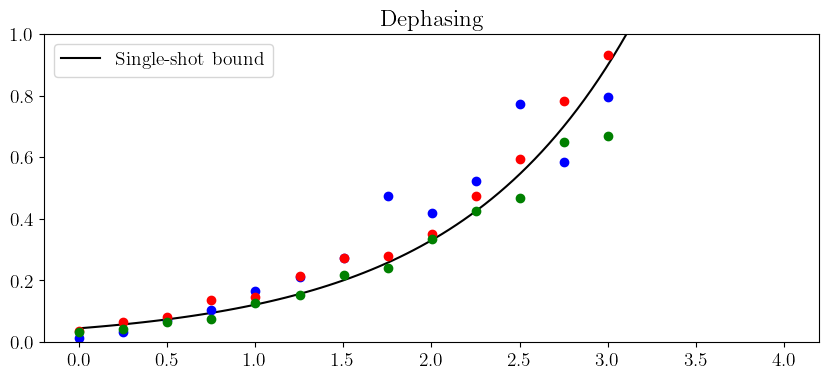

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))  # Adjust the figure size to make the plot longer
plt.rcParams['text.usetex'] = True
font = {'family': 'normal',
        'weight': 'bold',
        'size': 14}

plt.rc('font', **font)

plt.errorbar(W, np.array(errors_uniform_median_a[:,4]), yerr= np.array(errors_uniform_std_a[:,4]),
             fmt='o', color='blue')
plt.errorbar(W, np.array(errors_fisher_median_a[:,4]), yerr= np.array(errors_fisher_std_a[:,4]),
             fmt='o', color='red')
plt.errorbar(W, np.array(errors_local_median_a[:,4]), yerr= np.array(errors_local_std_a[:,4]), fmt='o',
             color='green')


def rao_bound_complex(T, a, sigma):
    I = 0
    for t in T:
        I += 1 / (sigma ** 2) * t ** 2 * np.exp(-2 * t * a)
    bound = 1 / np.sqrt(I)
    return bound

sigma_single = 1 / np.sqrt(shots/2)
Gamma = np.linspace(0, 4, 100)
error_single = []
for g in Gamma:
    error_single.append(rao_bound_complex([1], g, sigma_single))

plt.plot(Gamma, error_single, label='Single-shot bound', color='black')

plt.title("Dephasing")
# plt.title(f'Shots={Decay} ')
# plt.xlabel('$\omega')
# plt.ylabel('mean / $\gamma$')
plt.grid()
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim([0, 2])
plt.ylim([0, 1])

plt.grid()
plt.legend()

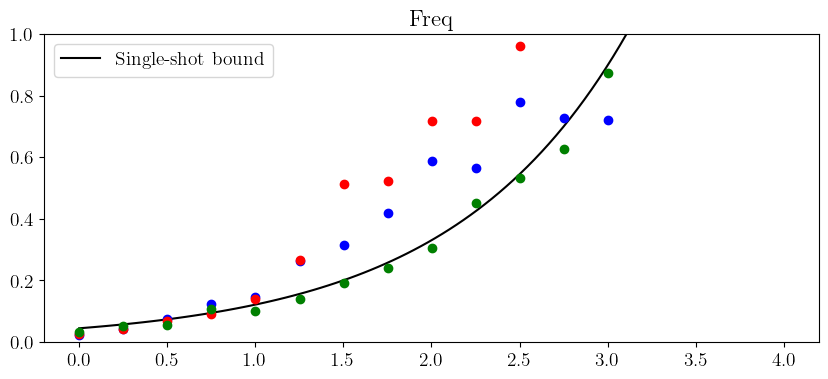

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))  # Adjust the figure size to make the plot longer
plt.rcParams['text.usetex'] = True
font = {'family': 'normal',
        'weight': 'bold',
        'size': 14}

plt.rc('font', **font)

plt.errorbar(W,  np.array(errors_uniform_median_w[:,4]), yerr= np.array(errors_uniform_std_w[:,4]),
             fmt='o', color='blue')
plt.errorbar(W,  np.array(errors_fisher_median_w[:,4]), yerr= np.array(errors_fisher_std_w[:,4]),
             fmt='o', color='red')
plt.errorbar(W,  np.array(errors_local_median_w[:,4]), yerr= np.array(errors_local_std_w[:,4]), fmt='o',
             color='green')
# plt.errorbar(Decay, 100 * np.array(errors_uniform_median_G/Decay ), yerr=100 * np.array(errors_uniform_std_G/Decay ), fmt='o',
#              color='magenta')
# Scatter points for 75th percentiles
plt.title("Freq")

# plt.title(f'Shots={Decay} ')
# plt.xlabel('$\omega')
# plt.ylabel('mean / $\omega$')
plt.grid()
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim([0, 2])
# plt.ylim([0,50])
sigma_single = 1 / np.sqrt(shots/2)
Gamma = np.linspace(0, 4, 100)
error_single = []
for g in Gamma:
    error_single.append(rao_bound_complex([1], g, sigma_single))

plt.plot(Gamma, error_single, label='Single-shot bound', color='black')
plt.ylim([0, 1])
plt.grid()

plt.legend()

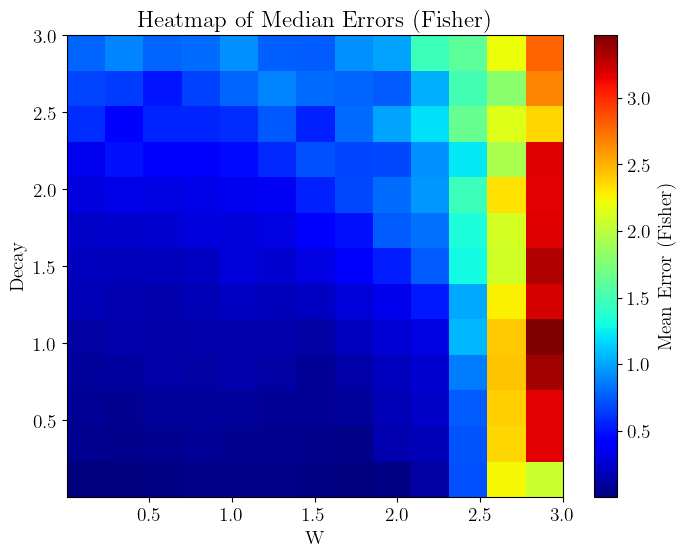

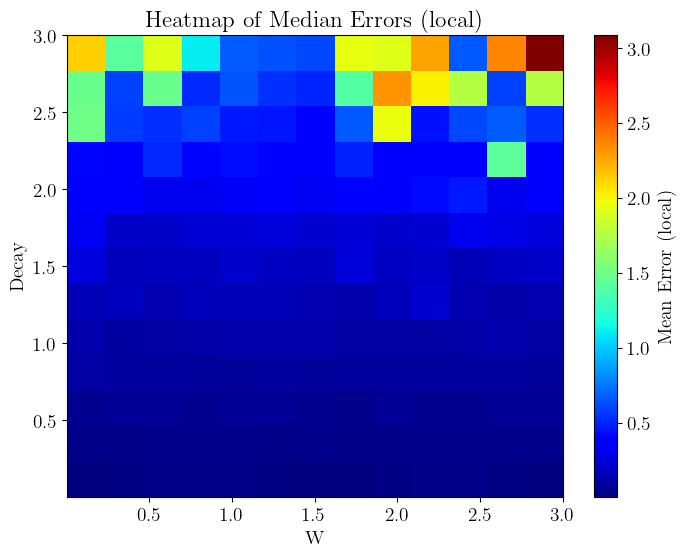

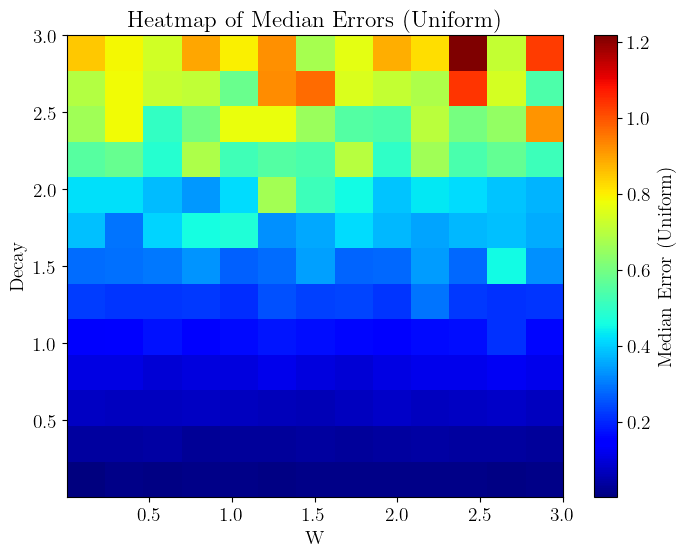

In [149]:
#Heatmap
# Plotting the heatmap
# sqrt_decay_w_array = np.zeros((len(Decay), len(W)))
# for i in range(len(Decay)):
#     for j in range(len(W)):
#         sqrt_decay_w_array[i, j] = np.sqrt(Decay[i]**2 + W[j]**2)
plt.figure(figsize=(8, 6))
plt.imshow(errors_fisher_median_a, aspect='auto', origin='lower',
           extent=[W.min(), W.max(), Decay.min(), Decay.max()], cmap='jet')
plt.colorbar(label='Mean Error (Fisher)')
plt.xlabel('W')
plt.ylabel('Decay')
plt.title('Heatmap of Median Errors (Fisher)')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(errors_local_median_a, aspect='auto', origin='lower',
           extent=[W.min(), W.max(), Decay.min(), Decay.max()], cmap='jet')
plt.colorbar(label='Mean Error (local)')
plt.xlabel('W')
plt.ylabel('Decay')
plt.title('Heatmap of Median Errors (local)')
plt.show()


plt.figure(figsize=(8, 6))
plt.imshow(errors_uniform_median_a, aspect='auto', origin='lower',
           extent=[W.min(), W.max(), Decay.min(), Decay.max()], cmap='jet')
plt.colorbar(label='Median Error (Uniform)')
plt.xlabel('W')
plt.ylabel('Decay')
plt.title('Heatmap of Median Errors (Uniform)')
plt.show()


Decay:  1.501
mean:  18.54041889923911
median:  14.700793648444346


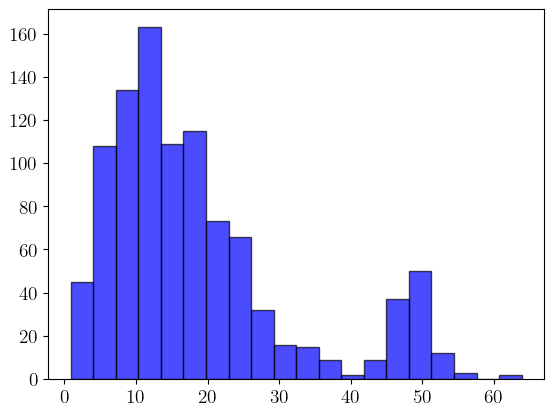

In [356]:
index = 6
X = np.array(100 * np.array(np.sqrt(errors_fisher_reshaped_a)))[index][:1000]
# print("Decay: ",Decay[index])
# print(X)
#plot histogram with 10 bins
plt.hist(X, bins=20, color='blue', edgecolor='black', alpha=0.7)
# q75, q25 = np.percentile(X, [75, 25])
# iqr = q75 - q25
print("Decay: ", Decay[index])
print("mean: ", np.mean(X))
print("median: ", np.median(X))
# print("IQR: ", iqr)
# print("std: ", np.std(X))

In [22]:
import os
import pandas as pd
user_home = os.path.expanduser("~")

results_df = pd.DataFrame({
    "shots": shots,
    "W": W,
    "errors_fisher_median_w": errors_fisher_median_w,
    "errors_fisher_std_w": errors_fisher_std_w,
    "errors_local_median_w": errors_local_median_w,
    "errors_local_std_w": errors_local_std_w,
    "errors_uniform_median_w": errors_uniform_median_w,
    "errors_uniform_std_w": errors_uniform_std_w,
})

# Saving to Excel
results_df.to_excel(user_home + r'\OneDrive - Bar-Ilan University - Students\Data\Crosstalk\graphs_for_paper\stability-detuning_w.xlsx',
    index=False)

results_df = pd.DataFrame({
    "shots": shots,
    "W": W,
    "errors_fisher_median_a": errors_fisher_median_a,
    "errors_fisher_std_a": errors_fisher_std_a,
    "errors_local_median_a": errors_local_median_a,
    "errors_local_std_a": errors_local_std_a,
    "errors_uniform_median_a": errors_uniform_median_a,
    "errors_uniform_std_a": errors_uniform_std_a,
})

# Saving to Excel
results_df.to_excel(
    user_home + r'\OneDrive - Bar-Ilan University - Students\Data\Crosstalk\graphs_for_paper\stability-detuning_a.xlsx',
    index=False)

In [151]:
fisher_a = []
local_a = []
uniform_a = []

fisher_w = []
local_w = []
uniform_w = []

for rep, rep_fits in enumerate(fitted_data):
    # Initialize lists for this repetition
    rep_fisher_a = []
    rep_local_a = []
    rep_uniform_a = []

    rep_fisher_w = []
    rep_local_w = []
    rep_uniform_w = []

    for w,d, (Decay_local, W_local, J_local), (Decay_fisher, W_fisher, J_fisher), (Decay_uni, W_uni, J_uni) in rep_fits:
        # Append decays
        rep_fisher_a.append(Decay_fisher)
        rep_local_a.append(Decay_local)
        rep_uniform_a.append(Decay_uni)

        # Append detunings
        rep_fisher_w.append(W_fisher)
        rep_local_w.append(W_local)
        rep_uniform_w.append(W_uni)

    fisher_a.append(rep_fisher_a)
    local_a.append(rep_local_a)
    uniform_a.append(rep_uniform_a)

    fisher_w.append(rep_fisher_w)
    local_w.append(rep_local_w)
    uniform_w.append(rep_uniform_w)



fisher_a = np.array(fisher_a).transpose()[0]
local_a = np.array(local_a).transpose()[0]
uniform_a = np.array(uniform_a).transpose()[0]



fisher_w= np.array(fisher_w).transpose()[0]
local_w = np.array(local_w).transpose()[0]
uniform_w = np.array(uniform_w).transpose()[0]


# fisher_a_mean = np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
# fisher_a_std =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
#
# local_a_mean =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
# local_a_std =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
#
# uniform_a_mean =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
# uniform_a_std =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
#
#
# fisher_w_mean =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
# fisher_w_std =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
#
# local_w_mean =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
# local_w_std =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
#
# uniform_w_mean =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))
# uniform_w_std =  np.zeros((len(W),len(W))),np.zeros((len(W),len(W)))

fisher_a_mean = [np.mean(fisher_a[i]) for i in range(len(W)**2)]
fisher_a_std = [np.std(fisher_a[i]) for i in range(len(W)**2)]

local_a_mean = [np.mean(local_a[i]) for i in range(len(W)**2)]
local_a_std = [np.std(local_a[i])  for i in range(len(W)**2)]

uniform_a_mean = [np.mean(uniform_a[i]) for i in range(len(W)**2)]
uniform_a_std = [np.std(uniform_a[i])  for i in range(len(W)**2)]


fisher_w_mean = [np.mean(fisher_w[i]) for i in range(len(W)**2)]
fisher_w_std = [np.std(fisher_w[i])  for i in range(len(W)**2)]

local_w_mean = [np.mean(local_w[i]) for i in range(len(W))]
local_w_std = [np.std(local_w[i])  for i in range(len(W)**2)]

uniform_w_mean = [np.mean(uniform_w[i]) for i in range(len(W)**2)]
uniform_w_std = [np.std(uniform_w[i]) for i in range(len(W)**2)]
#
#
def bias_matrix(matrix, true):
    B = np.zeros((len(W), len(W)))
    for i in range(len(W)):
        for j in range(len(W)):
            B[i, j] = matrix[i, j] - true[j]
    return np.array(B)

# print("Fisher_a: ", len(fisher_a))

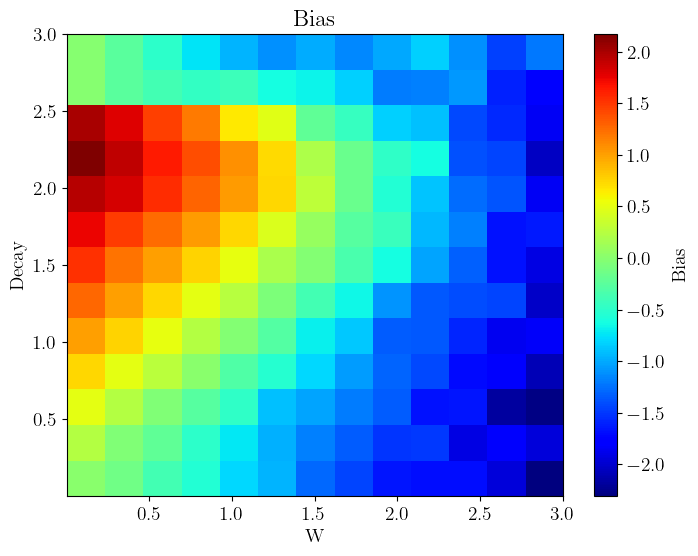

In [163]:

plt.figure(figsize=(8, 6))
res = np.array(fisher_w_mean).reshape((len(W),len(Decay)))
bias_a_fisher = bias_matrix(res,Decay)
plt.imshow(bias_a_fisher, aspect='auto', origin='lower',
           extent=[W.min(), W.max(), Decay.min(), Decay.max()], cmap='jet')
plt.colorbar(label='Bias')
plt.xlabel('W')
plt.ylabel('Decay')
plt.title('Bias')
plt.show()

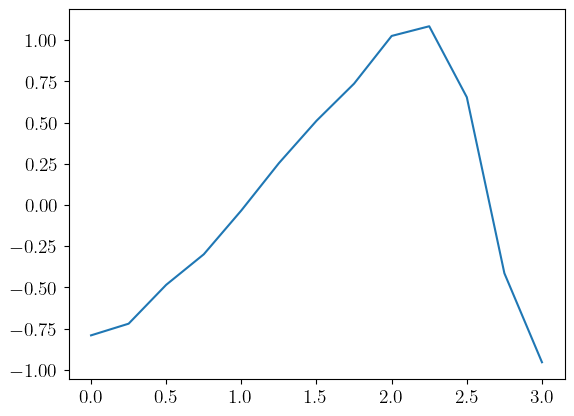

In [164]:
plt.plot(Decay,bias_a_fisher[:,4])


In [36]:
import os
import pandas as pd
user_home = os.path.expanduser("~")

results_df = pd.DataFrame({
    "shots": shots,
    "W": W,
    "fisher_a_mean": fisher_a_mean,
    "fisher_a_std": fisher_a_std,
    "local_a_mean": local_a_mean,
    "local_a_std": local_a_std,
    "uniform_a_mean": uniform_a_mean,
    "uniform_a_std": uniform_a_std,
    "fisher_w_mean": fisher_w_mean,
    "fisher_w_std": fisher_w_std,
    "local_w_mean": local_w_mean,
    "local_w_std": local_w_std,
    "uniform_w_mean": uniform_w_mean,
    "uniform_w_std": uniform_w_std,
})

# Saving to Excel
results_df.to_excel(user_home + r'\OneDrive - Bar-Ilan University - Students\Data\Crosstalk\graphs_for_paper\Unbiased_estimator_detuning.xlsx',
    index=False)


In [ ]:
# plt.plot(Decay,omega_fit_t_mean,label='fit')
plt.plot(Decay, [1] * len(Decay))
plt.errorbar(Decay, omega_fit_t_mean, yerr=omega_fit_t_std, label='std')

In [ ]:
from tqdm import tqdm
import random

T = 1 * np.pi
shots = 1000
errors_fisher = []
errors_local = []
uniform_local = []
uniform_local_G = []
n = 1
delay = [1]
fisher_delay = [0.4439410861020235, 1.784695781691183]

decay_fit = []

repetitions = 100
# W =]
Decay = np.arange(0.001, 4, 0.25)
# np.delete(W, 0)
W = [1]
J = {}
J_list = [random.gauss(1, 0) for _ in range(n - 1)]

for rep in range(repetitions):
    rep_Decay_fisher = []

    rep_decay_fit = []
    for decay in tqdm(Decay, desc=f"Repetition {rep}"):
        batch_x_det, batch_y_det, batch_x_cross, batch_y_cross = Ramsey_ExperimentV3.ramsey_local(n, shots, delay,
                                                                                                  [decay],
                                                                                                  W, J)
        Decay_local, W_local, J_local = estimator.one_by_one_fit(batch_x_det, batch_y_det, batch_x_cross,
                                                                 batch_y_cross)
        # batch_det, batch_cross = Ramsey_ExperimentV3.ramsey_local_X(n, shots, fisher_delay, [decay], W, J)
        # Decay_fisher, W_fisher, J_fisher = estimator.one_by_one_X(batch_det, batch_cross)

        rep_Decay_fisher.append(Decay_local)
    decay_fit.append(rep_Decay_fisher)



In [ ]:
import matplotlib.pyplot as plt
decay_fit_t = np.array(decay_fit).transpose()[0]
decay_fit_t_mean = [np.mean(decay_fit_t[i]) for i in range(len(Decay))]
decay_fit_t_std = [np.std(decay_fit_t[i]) / np.sqrt(repetitions) for i in range(len(Decay))]

# plt.plot(Decay,decay_fit_t_mean,label='fit')
plt.plot(Decay, Decay)
plt.errorbar(Decay, decay_fit_t_mean, yerr=decay_fit_t_std, label='std')
plt.legend()

In [ ]:
for w in W:
    for d in Decay:
